In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
import os
from torchvision import transforms
import torchaudio.transforms as T
from pathlib import Path

In [2]:
class AudioAugmentation:
    def __init__(self):
        self.gain = T.Vol(gain=0.5)
        self.noise_level = 0.01

    def __call__(self, waveform):
        if torch.rand(1).item() > 0.5:
            waveform = self.gain(waveform)

        # random noise
        noise = torch.randn_like(waveform) * self.noise_level
        waveform = waveform + noise

        return waveform

class VocalDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.augment = augment  # Augmentation added here
        self.classes = ['Laryngozele', 'Normal', 'Vox senilis']
        self.files = []
        for label in self.classes:
            class_path = self.root_dir / label
            self.files += [(f, label) for f in class_path.glob('*.wav')]

        self.feature_transform = T.MelSpectrogram(n_mels=128, n_fft=2048, hop_length=512)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        waveform, sample_rate = torchaudio.load(file_path)

        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        if self.augment:
            waveform = self.augment(waveform) # augmentation

        features = self.feature_transform(waveform)
        target_length = 128

        if features.size(2) < target_length:
            pad = target_length - features.size(2)
            features = torch.nn.functional.pad(features, (0, pad))
        else:
            features = features[:, :, :target_length]

        if self.transform:
            features = self.transform(features)

        label_idx = self.classes.index(label)
        return features, label_idx

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


In [4]:
root_dir = "/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset/patient-vocal-dataset"

# initing dataset with augmentation
augmentation = AudioAugmentation()
vocal_dataset = VocalDataset(root_dir=root_dir, augment=augmentation)

sample_waveform, _ = vocal_dataset[0]
print(f"Sample waveform shape: {sample_waveform.shape}")

Sample waveform shape: torch.Size([1, 128, 128])


In [5]:
##
##
# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
input_size = 128 * 128
hidden_size = 128
output_size = len(vocal_dataset.classes)
dropout_rate = 0.5

In [6]:
indices = list(range(len(vocal_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_subset = Subset(vocal_dataset, train_indices)
test_subset = Subset(vocal_dataset, test_indices)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [7]:
# Hyperparameter tuning using grid search
hyperparameters = {
    'batch_size': [32],
    'learning_rate': [0.001],
    'hidden_size': [128, 256],
    'dropout_rate': [0.5]
}

In [8]:

best_accuracy = 0
best_params = {}

for batch_size in hyperparameters['batch_size']:
    for learning_rate in hyperparameters['learning_rate']:
        for hidden_size in hyperparameters['hidden_size']:
            for dropout_rate in hyperparameters['dropout_rate']:
                model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dropout_rate=dropout_rate)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Adding L2 regularization
                l2_lambda = 0.001
                optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

                # Lists for metrics to plot
                train_losses = []
                train_accuracies = []
                val_accuracies = []

                for epoch in range(num_epochs):
                    model.train()
                    running_loss = 0.0
                    correct = 0
                    total = 0

                    for features, labels in train_loader:
                        features = features.view(features.size(0), -1, input_size)
                        optimizer.zero_grad()
                        outputs = model(features)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        running_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                    epoch_loss = running_loss / len(train_loader)
                    accuracy = 100 * correct / total
                    train_losses.append(epoch_loss)
                    train_accuracies.append(accuracy)

                    # Validation loop
                    model.eval()
                    with torch.no_grad():
                        correct = 0
                        total = 0

                        for features, labels in test_loader:
                            features = features.view(features.size(0), -1, input_size)
                            outputs = model(features)
                            _, predicted = torch.max(outputs.data, 1)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()

                        val_accuracy = 100 * correct / total
                        val_accuracies.append(val_accuracy)

                    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
                    print(f"Validation Accuracy for Epoch {epoch+1}: {val_accuracy:.2f}%")

                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'batch_size': batch_size, 'learning_rate': learning_rate, 'hidden_size': hidden_size, 'dropout_rate': dropout_rate}

print(f"Best validation accuracy: {best_accuracy:.2f}%")
print(f"Best hyperparameters: {best_params}")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/10], Loss: 1.0307, Accuracy: 46.14%
Validation Accuracy for Epoch 1: 62.50%
Epoch [2/10], Loss: 0.9052, Accuracy: 57.85%
Validation Accuracy for Epoch 2: 56.73%
Epoch [3/10], Loss: 0.8894, Accuracy: 55.43%
Validation Accuracy for Epoch 3: 55.77%
Epoch [4/10], Loss: 0.8937, Accuracy: 56.76%
Validation Accuracy for Epoch 4: 58.17%
Epoch [5/10], Loss: 0.8861, Accuracy: 57.61%
Validation Accuracy for Epoch 5: 60.58%
Epoch [6/10], Loss: 0.8767, Accuracy: 58.09%
Validation Accuracy for Epoch 6: 55.77%
Epoch [7/10], Loss: 0.8711, Accuracy: 60.63%
Validation Accuracy for Epoch 7: 61.06%
Epoch [8/10], Loss: 0.8550, Accuracy: 61.23%
Validation Accuracy for Epoch 8: 64.90%
Epoch [9/10], Loss: 0.8504, Accuracy: 61.35%
Validation Accuracy for Epoch 9: 65.87%
Epoch [10/10], Loss: 0.8602, Accuracy: 58.94%
Validation Accuracy for Epoch 10: 62.98%
Epoch [1/10], Loss: 0.9587, Accuracy: 52.78%
Validation Accuracy for Epoch 1: 56.73%
Epoch [2/10], Loss: 0.8542, Accuracy: 57.97%
Validation Accurac

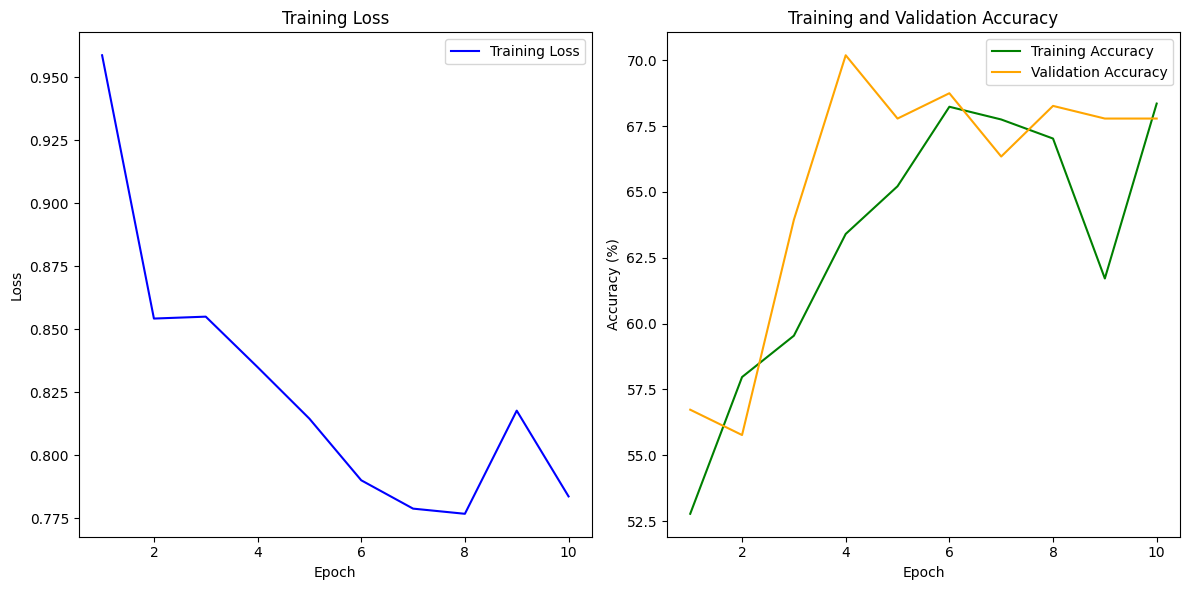

Best validation accuracy: 67.79%
Best hyperparameters: {'batch_size': 32, 'learning_rate': 0.001, 'hidden_size': 256, 'dropout_rate': 0.5}


In [9]:
plt.figure(figsize=(12, 6))

# plot of Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# plot of acc
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {best_accuracy:.2f}%")
print(f"Best hyperparameters: {best_params}")